<a href="https://colab.research.google.com/github/rizaho/ml_for_financial_analysis/blob/main/201_4_FACEBOOK_PROPHET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROPHET (FACEBOOK)

https://thedatahero.com/resources-forecasting-models-and-time-series-for-business-in-python/

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from google.colab import drive
import seaborn as sns
%matplotlib inline
from copy import copy
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # auto correlation, partial auto-correlation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.model_selection import ParameterGrid

# facebook prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# runtime settings
import sys
#np.set_printoptions(threshold=sys.maxsize)

## mount drive

In [2]:
# read data from google drive
drive.mount('/content/drive')
DATA_ROOT_PATH = "Python-Time-Series-Forecasting"
# /content/drive/MyDrive/Colab Notebooks/Python-Time-Series-Forecasting/Modern Time Series Forecasting Techniques/Prophet
DATA_SUB_INTRO = "Modern Time Series Forecasting Techniques/Prophet"
DRIVE_DATASET_PATH = "/content/drive/My Drive/Colab Notebooks/" + DATA_ROOT_PATH + "/" + DATA_SUB_INTRO + "/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%ls

drive/  sample_data/


In [4]:
# Daily Bike Sharing training.csv
df = pd.read_csv(DRIVE_DATASET_PATH + "Daily Bike Sharing training.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Preparing Data

In [5]:
# rename columns
df = df.rename(columns = {
    "cnt": "y",
    "dteday": "ds"
    })

# Change ds into YYYY-mm-dd
df["ds"] = pd.to_datetime(df["ds"], format="%m/%d/%Y")

df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
# Prepare the weather situation, make it categorical

weather_sit = pd.get_dummies(df["weathersit"], drop_first = True)
weather_sit

# concat weather_sit to df
df = pd.concat([df, weather_sit], axis = 1)
df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y,2,3
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,True,False
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,True,False
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,False,False
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,False,False
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,False,False


In [7]:
# rename new columns named, 2 and 3
df = df.rename(columns = {
    2: "weathersit_2",
    3: "weathersit_3"
    })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   instant       701 non-null    int64         
 1   ds            701 non-null    datetime64[ns]
 2   season        701 non-null    int64         
 3   yr            701 non-null    int64         
 4   mnth          701 non-null    int64         
 5   holiday       701 non-null    int64         
 6   weekday       701 non-null    int64         
 7   workingday    701 non-null    int64         
 8   weathersit    701 non-null    int64         
 9   temp          701 non-null    float64       
 10  atemp         701 non-null    float64       
 11  hum           701 non-null    float64       
 12  windspeed     701 non-null    float64       
 13  casual        701 non-null    int64         
 14  registered    701 non-null    int64         
 15  y             701 non-null    int64     

In [8]:
# Drop variables that are not needed
df.drop(
    columns = ["instant", "season", "yr", "mnth", "weekday", "casual", "registered"],
        axis = 1,
        inplace = True)
df.head()


,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False


# EDA

In [9]:
# Create a copy of the df with index
df_temp = df.copy()
df_temp.set_index("ds", inplace = True)
df_temp.head()

,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
ds,,,,,,,,,,
2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False
2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False
2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False
2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False
2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False


In [10]:
df_temp.index
# freq = None

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-11-22', '2012-11-23', '2012-11-24', '2012-11-25',
               '2012-11-26', '2012-11-27', '2012-11-28', '2012-11-29',
               '2012-11-30', '2012-12-01'],
              dtype='datetime64[ns]', name='ds', length=701, freq=None)

In [11]:
df_temp.index.freq = "D"
df_temp.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-11-22', '2012-11-23', '2012-11-24', '2012-11-25',
               '2012-11-26', '2012-11-27', '2012-11-28', '2012-11-29',
               '2012-11-30', '2012-12-01'],
              dtype='datetime64[ns]', name='ds', length=701, freq='D')

# Data visualization

## Plot y values

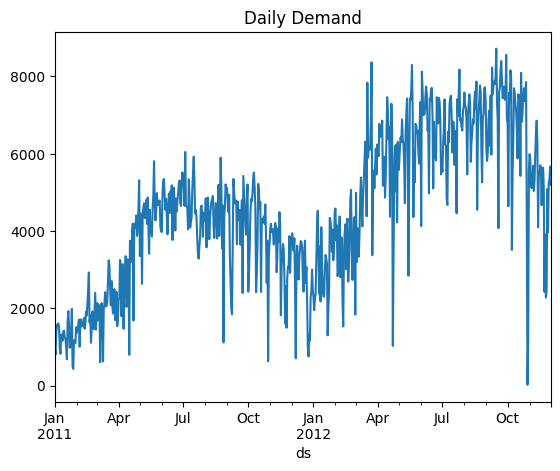

In [12]:
df_temp["y"].plot(title = "Daily Demand")
plt.show()
# There are some spikes (up and down)

## Monthly plot


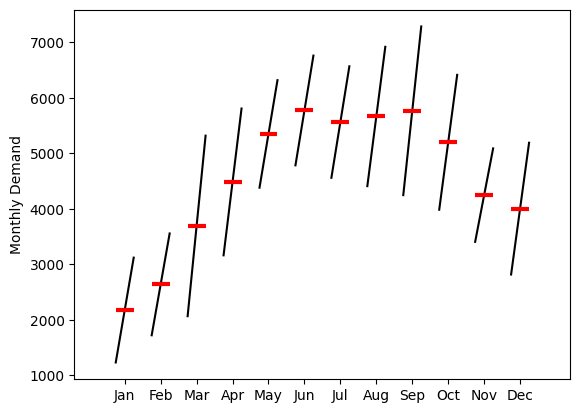

In [13]:
month_plot(df_temp["y"].resample("ME").mean(), ylabel="Monthly Demand")
plt.show()

## Quarterly plot

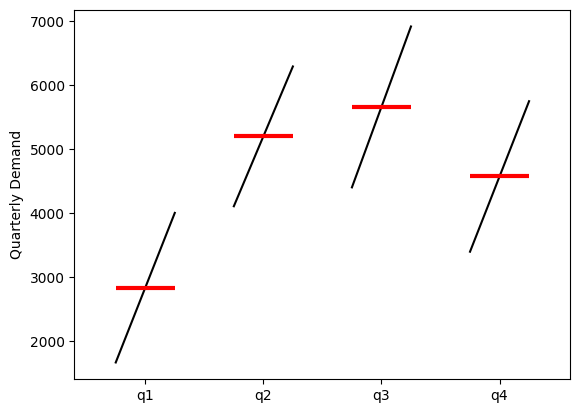

In [14]:
quarter_plot(df_temp["y"].resample("QE").mean(), ylabel="Quarterly Demand")
plt.show()

## Seasonal decomposition

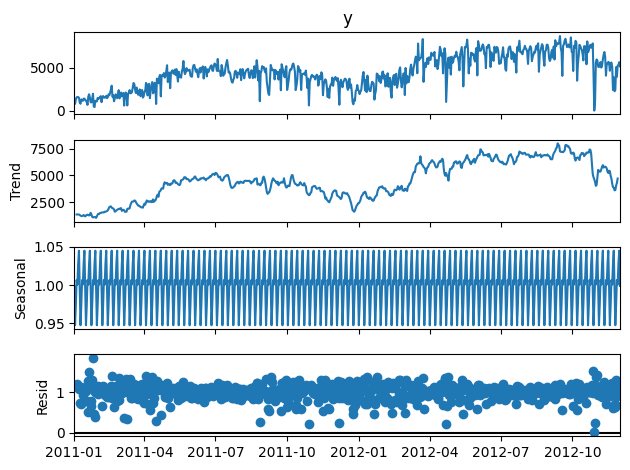

In [15]:
# plot seasonal decomposition
decomposition = seasonal_decompose(
    df_temp["y"],
    model = "mul",
    period = 7 # here we had used 365 before. But here we do not have 2 cycles!
    )

fig = decomposition.plot()
plt.show()
# We cannot get too much info from the plots

## Auto-correlation (correlation between daily data & lags)

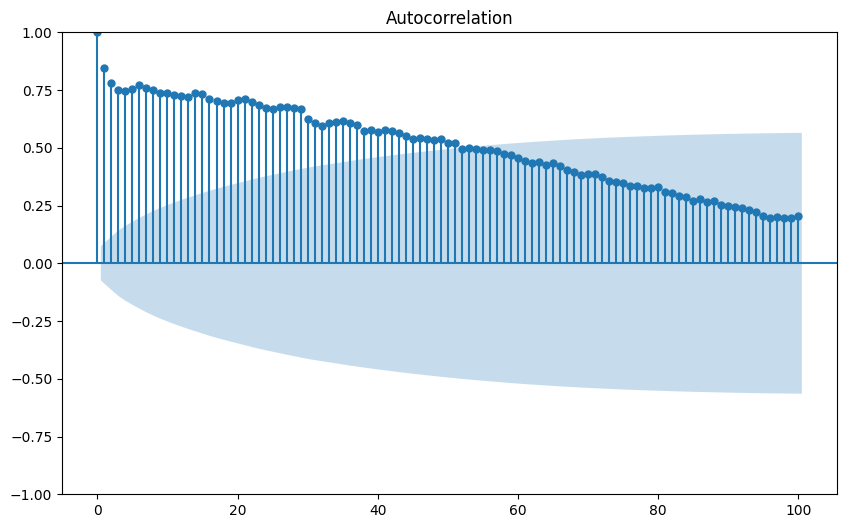

In [16]:
# Plot the autocorrelation (ACF)
fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(df_temp["y"], lags = 100, ax = ax)
plt.show()


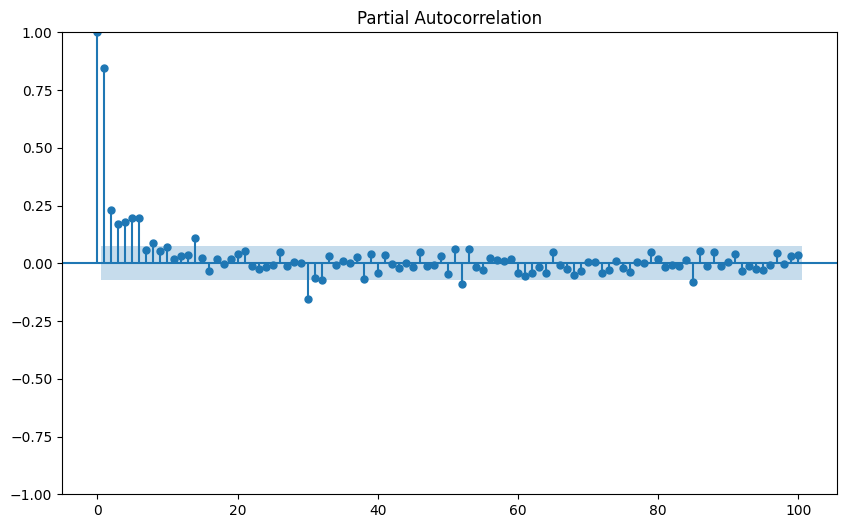

In [17]:
# Plot the partial autocorrelation (PACF)
fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(df_temp["y"], lags = 100, ax = ax)
plt.show()


# Dynamic holidays in Prophet

In [18]:
# Check the holidays in df
df[df.holiday == 1].ds

# This data is from Washington DC.
# Lets ask Chat GPT abou these days.

,ds
16,2011-01-17
51,2011-02-21
104,2011-04-15
149,2011-05-30
184,2011-07-04
247,2011-09-05
282,2011-10-10
314,2011-11-11
327,2011-11-24
359,2011-12-26


*	2011-01-17 (Martin Luther King Jr. Day)
*	2011-02-21 (Presidents' Day)
*	2011-04-15 (Emancipation Day observed in D.C.)
*	2011-05-30 (Memorial Day)
*	2011-07-04 (Independence Day)
*	2011-09-05 (Labor Day)
*	2011-10-10 (Columbus Day)
*	2011-11-11 (Veterans Day)
*	2011-11-24 (Thanksgiving Day)
*	2011-12-26 (Christmas Day observed, since Dec. 25 was a Sunday)
*	2012-01-02 (New Year's Day observed, since Jan. 1 was a Sunday)
*	2012-01-16 (Martin Luther King Jr. Day)
*	2012-02-20 (Presidents' Day)
*	2012-04-16 (Emancipation Day observed in D.C.)
*	2012-05-28 (Memorial Day)
*	2012-07-04 (Independence Day)
*	2012-09-03 (Labor Day)
*	2012-10-08 (Columbus Day)
*	2012-11-12 (Veterans Day observed, since Nov. 11 was a Sunday)
*	2012-11-22 (Thanksgiving Day)

## Prepare dataframe for the holidays

This holiday dataframe will be feeded to Prophet


In [19]:
# Holidays

# generic holidays from df
gen_holidays = pd.DataFrame({
    "holiday": "gen_holi",
    "ds": df[df.holiday == 1].ds,
    "lower_window": -2,
    "upper_window": 2
    })

# christmas holiday
xmas = pd.DataFrame({
    "holiday": "christmas",
    "ds": pd.to_datetime(["2011-12-24", "2012-12-24"]),
    "lower_window": -3,
    "upper_window": 3
    })

# new year eve
nye = pd.DataFrame({
    "holiday": "new_years",
    "ds": pd.to_datetime(["2011-12-31", "2012-12-31"]),
    "lower_window": -3,
    "upper_window": 3
    })

# easter
easter = pd.DataFrame({
    "holiday": "easter",
    "ds": pd.to_datetime(["2011-04-24", "2012-04-08"]),
    "lower_window": -3,
    "upper_window": 3
    })

In [20]:
# Combine all the holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter])
holidays

,holiday,ds,lower_window,upper_window
16,gen_holi,2011-01-17,-2,2
51,gen_holi,2011-02-21,-2,2
104,gen_holi,2011-04-15,-2,2
149,gen_holi,2011-05-30,-2,2
184,gen_holi,2011-07-04,-2,2
247,gen_holi,2011-09-05,-2,2
282,gen_holi,2011-10-10,-2,2
314,gen_holi,2011-11-11,-2,2
327,gen_holi,2011-11-24,-2,2
359,gen_holi,2011-12-26,-2,2


# Prophet Model Parameters

https://chatgpt.com/share/67da97d3-1d84-8008-9521-b6e73e4ae99a

## Main Prophet Model parameters

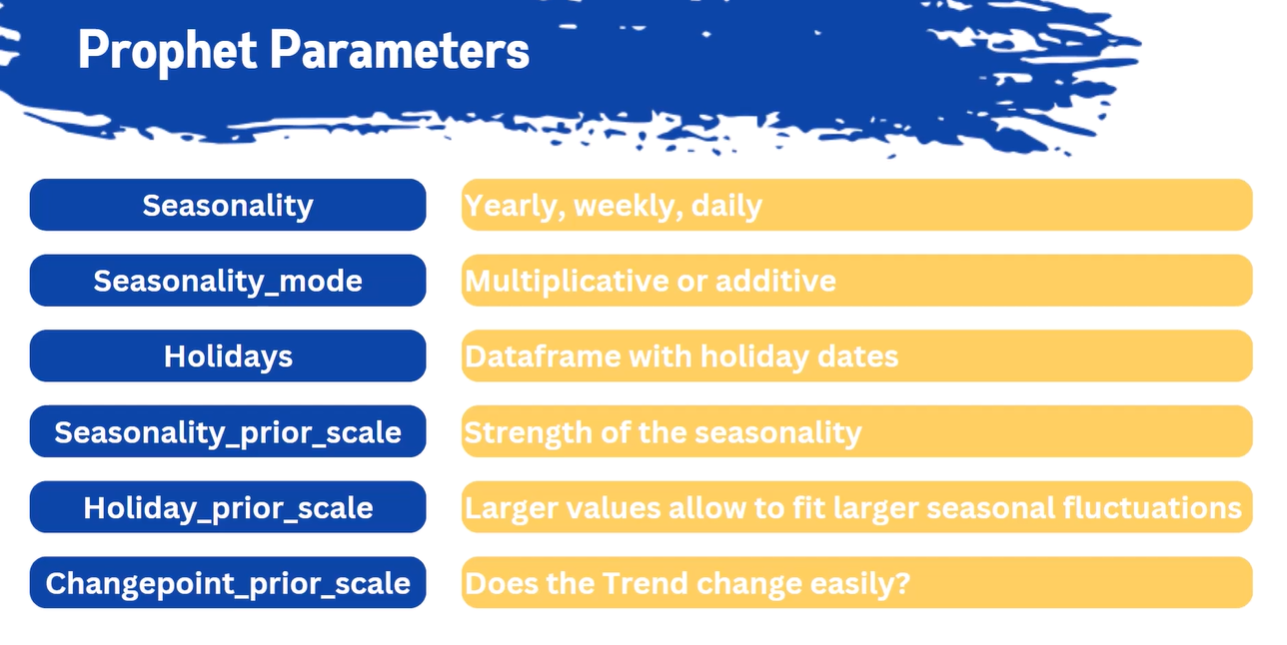

## Prophet Model

In [21]:
# drop any NA
df = df.dropna()
df.columns

Index(['ds', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'y', 'weathersit_2', 'weathersit_3'],
      dtype='object')

In [22]:
# Generally m is used in Prophet models.

# Create Prophet model with parameteters
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays = holidays,
    seasonality_mode = "multiplicative",
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    changepoint_prior_scale=0.05)

# add regressors (other variables that (we think) effect y variable)
m.add_regressor("workingday")
m.add_regressor("temp")
m.add_regressor("atemp")
m.add_regressor("hum")
m.add_regressor("windspeed")
m.add_regressor("weathersit_2")
m.add_regressor("weathersit_3")

m.fit(df)




INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpga8tqaau/8q_3n_bs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpga8tqaau/gy8ajyol.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94748', 'data', 'file=/tmp/tmpga8tqaau/8q_3n_bs.json', 'init=/tmp/tmpga8tqaau/gy8ajyol.json', 'output', 'file=/tmp/tmpga8tqaau/prophet_model6aaklyj6/prophet_model-20250319134830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:48:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:48:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Model Regressor coefficients

In [23]:
# print regressor coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,workingday,multiplicative,0.000000,0.156059,0.156059,0.156059
1,temp,multiplicative,0.502732,0.772499,0.772499,0.772499
2,atemp,multiplicative,0.480847,0.238002,0.238002,0.238002
3,hum,multiplicative,0.625717,-0.381424,-0.381424,-0.381424
4,windspeed,multiplicative,0.190534,-0.617760,-0.617760,-0.617760
5,weathersit_2,multiplicative,0.000000,-0.103630,-0.103630,-0.103630
6,weathersit_3,multiplicative,0.000000,-0.477096,-0.477096,-0.477096


## Cross-Validation

In [27]:
print(f"Number of the rows for cross validation: {df.shape[0] - 180}")

Number of the rows for cross validation: 521


In [28]:
df_cv = cross_validation(
    model = m,
    period = "15 days",
    initial = "521 days",
    horizon = "30 days", # test data length. We will predict for the next 15 days.
    parallel = "processes")

df_cv.head()

INFO:prophet:Making 10 forecasts with cutoffs between 2012-06-19 00:00:00 and 2012-11-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7bdc24e46090>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpga8tqaau/8gs3zcbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpga8tqaau/i0sn4ehl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpga8tqaau/b95e8d3p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpga8tqaau/soq8mxiy.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33815', 'data', 'file=/tmp/tmpga8tqaau/8gs3zcbr.json', 'init=/tmp/tmpga8tqaau/b95e8d3p.json', 'output', 'file=/tmp/tmpga8tqaau/prophet_modelv42l4kl4/prophet_model-20250319135620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:idx 0
13:56:20 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:runnin

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8164.530748,7433.580301,8847.781176,6211,2012-06-19
1,2012-06-21,8651.646441,7921.318396,9385.348132,5905,2012-06-19
2,2012-06-22,8332.067439,7630.610777,9017.596327,5823,2012-06-19
3,2012-06-23,7910.131333,7185.452938,8610.089989,7458,2012-06-19
4,2012-06-24,7982.814691,7319.874647,8737.632525,6891,2012-06-19


## Performance metrics

### cross validation parameters

In [29]:
df_cv.head()
# ds: the day that we got the forecast for.
# cutoff: when the forecast is done.
# y: what actually happened
# yhat, yhat_lower and yhat_upper are the predictions.

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8164.530748,7433.580301,8847.781176,6211,2012-06-19
1,2012-06-21,8651.646441,7921.318396,9385.348132,5905,2012-06-19
2,2012-06-22,8332.067439,7630.610777,9017.596327,5823,2012-06-19
3,2012-06-23,7910.131333,7185.452938,8610.089989,7458,2012-06-19
4,2012-06-24,7982.814691,7319.874647,8737.632525,6891,2012-06-19


### print the performance metrics using performance_metrics

In [32]:
# print the performance metrics using performance_metrics
df_p = performance_metrics(df_cv)
df_p

# we will focus on rmse and mape


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.618402e+06,1272.164146,942.588358,0.164065,0.095239,0.157414,0.566667
1,4 days,1.499301e+06,1224.459398,891.608308,0.148523,0.082223,0.144701,0.600000
2,5 days,1.568345e+06,1252.335961,955.739347,0.155582,0.079298,0.150794,0.533333
3,6 days,1.199923e+06,1095.409830,878.600891,0.138146,0.105343,0.139009,0.566667
4,7 days,1.238476e+06,1112.868150,881.088676,0.134497,0.105343,0.139622,0.566667
5,8 days,9.712360e+05,985.513056,761.916536,0.107677,0.099503,0.117101,0.600000
6,9 days,9.200156e+05,959.174430,740.484081,0.103126,0.092082,0.110967,0.566667
7,10 days,1.422051e+06,1192.497609,904.677273,0.130911,0.110422,0.134387,0.500000
8,11 days,1.565079e+06,1251.031249,945.502639,0.141845,0.091275,0.142661,0.533333
9,12 days,2.086008e+06,1444.302006,1133.751926,4.071184,0.121440,0.225230,0.466667


In [33]:
df_p.mean()

,0
horizon,16 days 12:00:00
mse,1776632.858949
rmse,1320.21717
mae,1019.328735
mape,1.010491
mdape,0.108935
smape,0.181402
coverage,0.516667


In [45]:
rmse = round(performance_metrics(df_cv)["rmse"].mean(), 0)
mape = round(performance_metrics(df_cv)["mape"].mean() * 100, 2 ) # this is percentage
print(f"RMSE: {rmse} and MAPE (Mean Absolute Percentage Error): {mape} %")

# here mape is very big

RMSE: 1320.0 and MAPE (Mean Absolute Percentage Error): 101.05 %


### mape is very big

/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


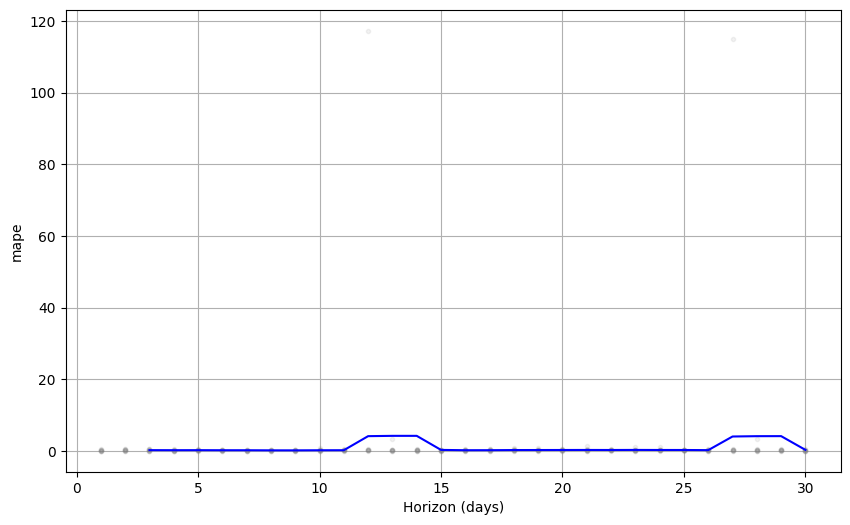

In [49]:
# Plotting the metrics over time
fig = plot_cross_validation_metric(df_cv, metric='mape')

# below we can see some outliers around 120 (in the y axis)

# lets check the data set and explore